In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
from pathlib import Path
csvpath = Path('../data/cleandata/Data.csv')
df = pd.read_csv(csvpath, parse_dates=True, index_col='Date')
df.head()

,Crude1,WTI_Midland,Brent,RBOB,Ethanol,Corn,CAD_Heavy,VIX,ULSD,OPEC_Basket,RBOB_Crack,GC_ULSD_Crack,NY_ULSD_Crack,NG_HB,S_P,VLO
Date,,,,,,,,,,,,,,,,
2017-01-05,53.76,-0.06,56.89,1.6377,1.507,361.25,-15.044,13.025,1.6942,53.02,21.45,14.58,17.13,3.273,2264.3,60.913052
2017-01-06,53.99,-0.11,57.10,1.6340,1.551,358.00,-14.459,12.875,1.7032,53.50,21.45,14.69,17.27,3.285,2271.5,59.995037
2017-01-09,51.96,-0.22,54.94,1.5707,1.524,360.00,-14.296,12.925,1.6376,52.85,20.94,14.27,16.68,3.103,2265.0,59.734032
2017-01-10,50.82,-0.17,53.64,1.5467,1.503,358.25,-14.193,12.875,1.6114,51.46,21.15,14.44,16.72,3.278,2263.7,59.878029
2017-01-11,52.25,-0.17,55.10,1.5929,1.492,357.25,-14.232,12.525,1.6524,50.98,21.64,14.67,16.96,3.224,2270.6,60.373043


In [4]:
df['Return'] = df['VLO'].pct_change() * 100
df['Lagged_Return'] = df.Return.shift()
df = df.dropna()
df.head()

,Crude1,WTI_Midland,Brent,RBOB,Ethanol,Corn,CAD_Heavy,VIX,ULSD,OPEC_Basket,RBOB_Crack,GC_ULSD_Crack,NY_ULSD_Crack,NG_HB,S_P,VLO,Return,Lagged_Return
Date,,,,,,,,,,,,,,,,,,
2017-01-09,51.96,-0.22,54.94,1.5707,1.524,360.00,-14.296,12.925,1.6376,52.85,20.94,14.27,16.68,3.103,2265.0,59.734032,-0.435044,-1.507091
2017-01-10,50.82,-0.17,53.64,1.5467,1.503,358.25,-14.193,12.875,1.6114,51.46,21.15,14.44,16.72,3.278,2263.7,59.878029,0.241064,-0.435044
2017-01-11,52.25,-0.17,55.10,1.5929,1.492,357.25,-14.232,12.525,1.6524,50.98,21.64,14.67,16.96,3.224,2270.6,60.373043,0.826704,0.241064
2017-01-12,53.01,-0.22,56.01,1.6108,1.475,358.25,-14.234,12.475,1.6756,52.30,21.59,14.63,17.08,3.386,2263.4,59.869034,-0.834825,0.826704
2017-01-13,52.37,-0.27,55.45,1.6117,1.476,358.50,-14.203,12.175,1.6514,52.64,22.24,14.42,16.88,3.419,2272.5,59.752033,-0.195428,-0.834825


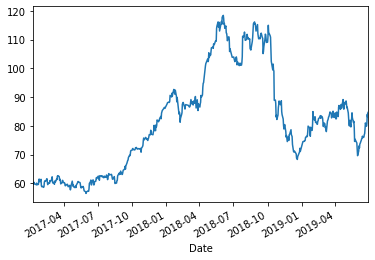

In [5]:
df['VLO'].plot()

# Train Test Split Predictions

Training Period: 2017-2018
Testing Period: 2019

In [6]:
# Create a train/test split for the data using 2001-2018 for training and 2019 for testing
train = df['2017':'2018']
test = df['2019']

In [7]:
# Create train and test sets for dependent and independent variables
X_train = train["Lagged_Return"].to_frame()
y_train = train["Return"]
X_test = test["Lagged_Return"].to_frame()
y_test = test["Return"]

In [8]:
# Create and fit model to the data, make predictions
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [9]:
# Construct a dataframe using just the "y" training data:
out_of_sample_results = y_test.to_frame()

# Add a column of "out-of-sample" predictions to that dataframe:  
out_of_sample_results["Out-of-Sample Predictions"] = model.predict(X_test)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000232DE592C08>,
      dtype=object)

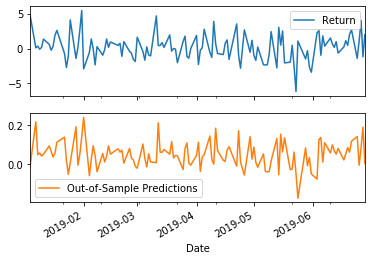

In [10]:
# Plot the out-of-sample results for 2019
out_of_sample_results.plot(subplots=True)

In [11]:
# Calculate out-of-sample mean_squared_error (for comparison to out-of-sample)
out_of_sample_mse = mean_squared_error(
    out_of_sample_results["Return"],
    out_of_sample_results["Out-of-Sample Predictions"]
)

# Calculate out-of-sample root mean_squared_error (for comparison to out-of-sample)
out_of_sample_rmse = np.sqrt(out_of_sample_mse)
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

Out-of-sample Root Mean Squared Error (RMSE): 1.8860797265840252


---

# Rolling Out-of-Sample Predictions

In [12]:
# Split the index into weekly periods
weeks = df.index.to_period("w").unique()
print(weeks[0])

2017-01-09/2017-01-15


In [13]:
# Declare the training window of 12 weeks
# Define the imeframe of rolling windows
training_window = 12
timeframe = len(weeks) - training_window - 1
print(timeframe)

116


In [14]:
# Construct empty placeholder dataframes.
# (During each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
all_actuals = pd.DataFrame(columns=["Actual Returns"])

In [15]:
# During rolling iteration, split into train and test sets.
# Use linear regression to make out-of-sample predictions.
# Append the results to external dataframes.
for i in range(0, timeframe):
    
    # Beginning of training window
    start_of_training_period = weeks[i].start_time.strftime(format="%Y-%m-%d")
    
    # End of training window
    end_of_training_period = weeks[training_window+i].end_time.strftime(format="%Y-%m-%d")

    # Window of test-window data
    test_week = weeks[training_window + i + 1]
    
    # String of testing window
    start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
    end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
    
    train = df.loc[start_of_training_period:end_of_training_period]
    test = df.loc[start_of_test_week:end_of_test_week]
    
    # Create new dataframes:
    X_train = train["Lagged_Return"].to_frame()
    y_train = train["Return"]
    X_test = test["Lagged_Return"].to_frame()
    y_test = test["Return"]

    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Create a temporary dataframe to hold predictions
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
    
    # Create a temporary DataFrame of the actual "y"s in the test dataframe, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns"]  
    
    # Append these two dataframes (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)   
    

In [16]:
Results = pd.concat([all_actuals, all_predictions], axis=1)
Results.head()

,Actual Returns,Out-of-Sample Predictions
2017-04-10,-0.335516,-0.082651
2017-04-11,0.428441,0.026471
2017-04-12,-0.761843,-0.049046
2017-04-13,-0.690918,0.068614
2017-04-17,0.788499,0.054198


In [17]:
# 2019 Data
results_2019 = Results.loc['2019':]
results_2019

,Actual Returns,Out-of-Sample Predictions
2019-01-04,4.804015,-0.724144
2019-01-07,0.103879,-0.533138
2019-01-08,0.350245,-0.672256
2019-01-09,-0.090485,-0.664964
2019-01-10,0.168197,-0.678009
...,...,...
2019-06-24,-1.403981,-0.127463
2019-06-25,1.077264,0.036722
2019-06-26,4.042628,-0.062339
2019-06-27,-1.177435,-0.180729


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000232DE695AC8>,
      dtype=object)

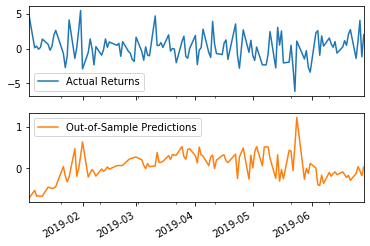

In [18]:
# Plot the results
results_2019.plot(subplots=True)

In [19]:
# Out-of-sample metrics
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe above)
mse = mean_squared_error(
    results_2019["Actual Returns"],
    results_2019["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rolling_rmse = np.sqrt(mse)
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse}")

Rolling Out-of-Sample Root Mean Squared Error (RMSE): 1.9531922799719263


# Final Model Comparison

In [20]:
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse}")

Out-of-sample Root Mean Squared Error (RMSE): 1.8860797265840252
Rolling Out-of-Sample Root Mean Squared Error (RMSE): 1.9531922799719263


Comparing the two RMSE's, the RMSE from the single training window is 0.73, whereas it is 0.75 from the rolling-out-of-sample model.

* The rolling-out-of sample approach is an approach more akin to real life (you likely re-estimate your model when new data becomes available)
* In addition to being more realistic, the rolling-out of sample approach is also more rigorous, as you are testing your model many more times across different time periods
* Therefore, we expect a slightly higher out-of-sample RMSE, which is what we see.
* The fact that the two are close to each other in value though does suggest that our model is reasonably stable.